<a href="https://colab.research.google.com/github/mobarakol/Surgical_SceneGraph_Generation/blob/main/reading_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains a sample code on how to read the datsaet for MICCAI2020 paper [Learning and Reasoning with the Graph Structure Representation in Robotic Surgery](https://arxiv.org/pdf/2007.03357.pdf) 

Tool-tissue interaction graph annotation on [2018 Robotic Scene Segmentation Challenge dataset](https://arxiv.org/abs/2001.11190) can be downloaded from [google drive](https://drive.google.com/file/d/16G_Pf4E9KjVq7j_7BfBKHg0NyQQ0oTxP/view). The xml contains both bounding box annotation and interaction class annotation.

Downloading validation set only

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = ['1OwWfgBZE0W5grXVaQN63VUUaTvufEmW0']
downloaded = drive.CreateFile({'id':id[0]}) 
downloaded.GetContentFile('gr_mtl_ssu_dataset.zip')
!unzip -q gr_mtl_ssu_dataset.zip

Reading a sample image and corresponding bounding box and tool-tissue interaction

Object: kidney interaction: Idle
Object: bipolar_forceps interaction: Idle
Object: prograsp_forceps interaction: Tissue_Manipulation
Object: monopolar_curved_scissors interaction: Tissue_Manipulation


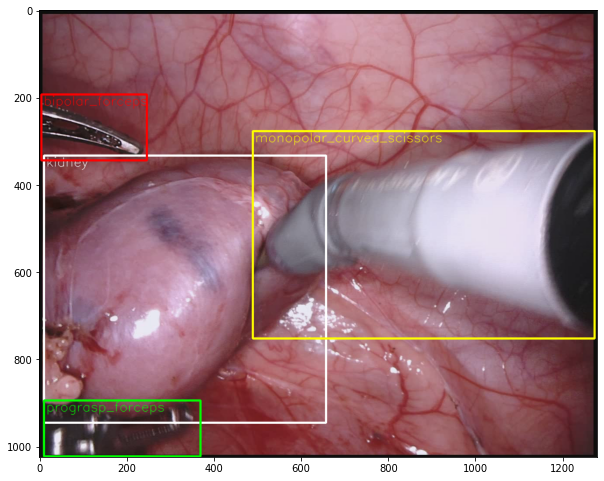

In [2]:
import os
import sys
import cv2
from glob import glob
from PIL import Image
%matplotlib inline
from matplotlib import pyplot as plt

if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

instrument_classes = ('kidney', 'bipolar_forceps', 'prograsp_forceps', 'large_needle_driver',
                                   'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier',
                                   'stapler', 'maryland_dissector', 'spatulated_monopolar_cautery')

action_classes = ('Idle', 'Grasping', 'Retraction', 'Tissue_Manipulation',
                               'Tool_Manipulation', 'Cutting', 'Cauterization',
                               'Suction', 'Looping', 'Suturing', 'Clipping', 'Staple',
                               'Ultrasound_Sensing')


font = cv2.FONT_HERSHEY_SIMPLEX

color_mode = [(0,0,255),(0,255,0),(255,0,0),(0,255,255),(255,0,255),(255,255,0),(255,255,255)]
img_path = 'dataset/seq_1/left_frames/frame000.png'
_img_orig = Image.open(img_path).convert('RGB')
img  = cv2.imread(img_path)
_xml_dir = os.path.dirname(os.path.dirname(img_path)) + '/xml/' + os.path.basename(img_path[:-4]) + '.xml'
_xml = ET.parse(_xml_dir).getroot()
class_to_ind = dict(zip(instrument_classes, range(len(instrument_classes))))
plt.figure(figsize=(10, 10))

for obj in _xml.iter('objects'):
    name = obj.find('name').text.strip()
    interaction = obj.find('interaction').text.strip()
    print('Object:',name, 'interaction:',interaction)
    bbox = obj.find('bndbox')
    bbox_col = instrument_classes.index(str(name)) - 1;
    pts = ['xmin', 'ymin', 'xmax', 'ymax']
    bndbox = []
    label_idx = class_to_ind[name]
    for i, pt in enumerate(pts):         
        cur_pt = int(bbox.find(pt).text)
        bndbox.append(cur_pt)
        
    top_corner, down_corner = (int(bndbox[0]), int(bndbox[1])), (int(bndbox[2]), int(bndbox[3]))
    cv2.rectangle(img, top_corner, down_corner, color_mode[bbox_col], thickness=4)
    cv2.putText(img,str(name),(top_corner[0]+5, top_corner[1]+25), font, 1,color_mode[bbox_col],1,cv2.LINE_AA)       
    plt.imshow(img[:,:,::-1])



# Combining two bounding boxes

Object: kidney interaction: Idle
Object: bipolar_forceps interaction: Idle
Object: prograsp_forceps interaction: Tissue_Manipulation
Object: monopolar_curved_scissors interaction: Tissue_Manipulation


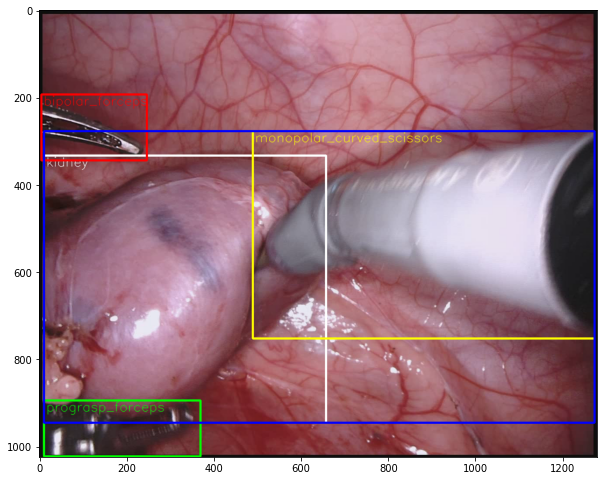

In [42]:
img  = cv2.imread(img_path)
plt.figure(figsize=(10, 10))
combined_bbox = []
for obj in _xml.iter('objects'):
    name = obj.find('name').text.strip()
    interaction = obj.find('interaction').text.strip()
    print('Object:',name, 'interaction:',interaction)
    bbox = obj.find('bndbox')
    bbox_col = instrument_classes.index(str(name)) - 1;
    pts = ['xmin', 'ymin', 'xmax', 'ymax']
    bndbox = []
    
    label_idx = class_to_ind[name]
    for i, pt in enumerate(pts):         
        cur_pt = int(bbox.find(pt).text)
        bndbox.append(cur_pt)
    if name == 'kidney' or name == 'monopolar_curved_scissors':
        combined_bbox.append(bndbox)
        
    top_corner, down_corner = (int(bndbox[0]), int(bndbox[1])), (int(bndbox[2]), int(bndbox[3]))
    cv2.rectangle(img, top_corner, down_corner, color_mode[bbox_col], thickness=4)
    cv2.putText(img,str(name),(top_corner[0]+5, top_corner[1]+25), font, 1,color_mode[bbox_col],1,cv2.LINE_AA)       
    
combined_bbox = np.array(combined_bbox)
cxmin = min(combined_bbox[:,0])
cymin = min(combined_bbox[:,1])
cxmax = max(combined_bbox[:,2])
cymax = max(combined_bbox[:,3])
cbbx = [cxmin, cymin, cxmax, cymax]

top_corner, down_corner = (int(cbbx[0]), int(cbbx[1])), (int(cbbx[2]), int(cbbx[3]))
cv2.rectangle(img, top_corner, down_corner, color_mode[2], thickness=4)

plt.imshow(img[:,:,::-1])

In [24]:
np.array(combined_bbox)

array([[  11,  333,  658,  945],
       [ 490,  277, 1274,  752]])

In [29]:
combined_bbox = np.array(combined_bbox)
combined_bbox, combined_bbox.shape, 

(array([[  11,  333,  658,  945],
        [ 490,  277, 1274,  752]]), (2, 4))

In [26]:
import numpy as np
np.array(combined_bbox)[:,1], min(np.array(combined_bbox)[:,1])


(array([333, 277]), 277)

In [33]:
cxmin = min(combined_bbox[:,0])
cymin = min(combined_bbox[:,1])
cxmax = min(combined_bbox[:,2])
cymax = min(combined_bbox[:,3])
cxmin, cymin, cxmax, cymax

(11, 277, 658, 752)